<a href="https://colab.research.google.com/github/0seoyeon/tobigs-21st/blob/%EA%B3%B5%EC%84%9C%EC%97%B0/Week4/Dimensionality%20Reduction/%EA%B3%B5%EC%84%9C%EC%97%B0/Tobigs_Week4_Dimensionality_Reudction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA & LDA on MNIST

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## 1. Train KNN on MNIST Dataset

In [2]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 98947382.66it/s]


Extracting ./data/02/MNIST/raw/train-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67939256.21it/s]

Extracting ./data/02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/02/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27746694.68it/s]


Extracting ./data/02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16022311.83it/s]


Extracting ./data/02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/02/MNIST/raw

number of training data :  60000
number of test data :  10000


In [9]:
# 데이터 모양 확인을 위해 dataframe 형태로 변환

feat_cols = ['pixel'+str(i) for i in range(784)] # size of a picture: 28 × 26 = 784
df_train = pd.DataFrame(train_data.data.reshape(60000,-1).numpy(), columns = feat_cols)
df_test = pd.DataFrame(test_data.data.reshape(10000,-1).numpy(), columns = feat_cols)

df_train.shape, df_test.shape

((60000, 784), (10000, 784))

In [10]:
df_train.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

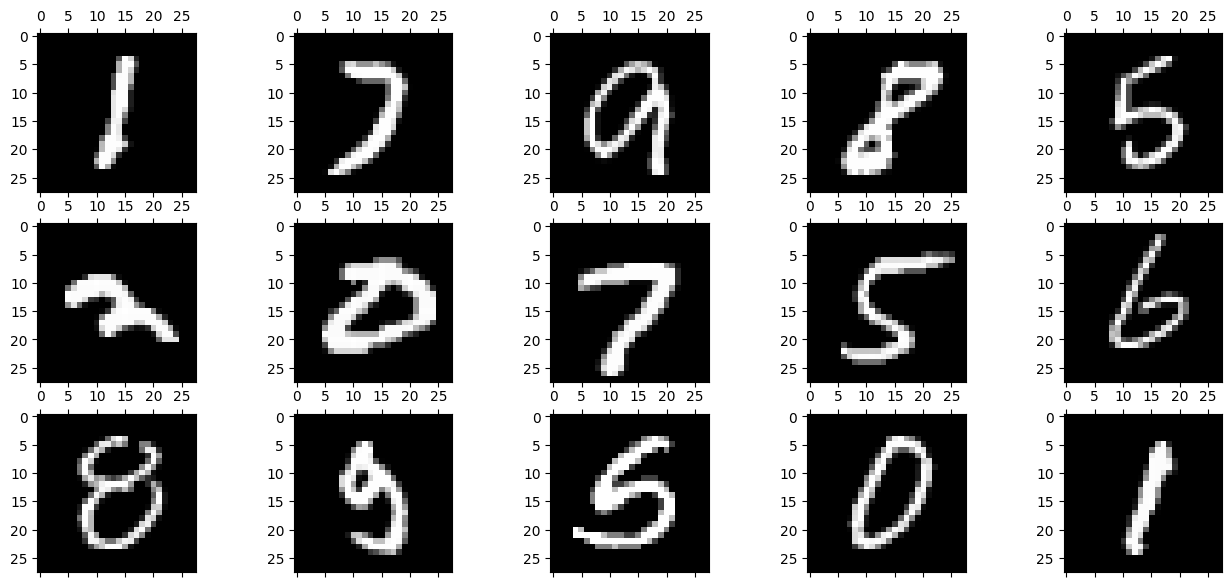

In [14]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt

rndperm = np.random.permutation(df_train.shape[0]) # 60000개의 이미지 중에 무작위로 순열 생성해서 15개의 이미지만 무작위로 확인하겠다.

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df_train.loc[rndperm[i], feat_cols].values.reshape((28,28)).astype(float)) # 다시 28 × 28 형태로 변환해서 이미지 확인하기
plt.show()

In [15]:
# 학습 데이터 준비

import numpy as np

X_train = train_data.data.reshape(60000,-1).numpy() # data : 이미지
y_train = train_data.targets.numpy() # targets : 해당 숫자 (array([5, 0, 4, ..., 5, 6, 8]))

X_test = test_data.data.reshape(10000,-1).numpy()
y_test = test_data.targets.numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [17]:
# KNN 학습 - Baseline

from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  0.012818574905395508


In [19]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Predict time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Predict time :  49.25942349433899
0.9688


## 2. PCA & LDA 적용하기

In [20]:
# PCA 적용

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf_pca = KNeighborsClassifier(n_neighbors= 5)
clf_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

In [22]:
# LDA 적용

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
X_train_lda = lda.transform(X_train)

In [23]:
X_train_lda.shape # 차원이 줄어든 것 (784 -> 6) 확인 가능하다.

(60000, 9)

In [24]:
lda.explained_variance_ratio_ # 각 속성이 설명하는 분산의 양

array([0.2392286 , 0.20180995, 0.17849695, 0.10652571, 0.09406712,
       0.06906025, 0.04973746, 0.03429077, 0.0267832 ])

## 3. 결과 비교하기

In [25]:
# PCA 결과
start_time = time.time()
pred = clf_pca.predict(X_test_pca)
print('Predict time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Predict time :  48.92106890678406
0.9688


In [26]:
# LDA 결과
start_time = time.time()
y_pred = lda.predict(X_test)
print('Predict time : ', time.time() - start_time)
print(accuracy_score(y_test, y_pred))

Predict time :  0.0670328140258789
0.873


## 4. PCA & LDA 장단점 정리하기

####장단점을 자유롭게 적어주세요!

- PCA
  - 장점: 1) 클래스 레이블 없는 데이터에도 적용할 수 있다. 2) 데이터의 차원을 줄이고 노이즈를 제거하는 데 효과적이다.
  - 단점: 1) 주성분은 데이터의 분산을 최대화하는 방향으로 정의되나, 어떤 특성을 나타내는지는 명확하지 않다. 2) 주성분을 모든 변수들의 선형결합 형태로 정의하여, 노이즈를 포함하거나 주성분의 해석이 불분명해지거나, 다중공선성 문제가 발생할 수 있다. 그러나 이러한 문제를 주요 변수들만을 고려한 희소 주성분 분석(Sparse PCA)을 사용해서 극복한다. 3) Variance 연산 시 제곱 계산을 하기 때문에 outliers에 취약하다.

- LDA
  - 장점: classifier가 아니지만 클래스간 거리가 최대로 되게 하기 때문에 class 분류에 이용할 수 있다.
  - 단점: 1) 비선형적인 분포를 가지는 데이터에는 적합하지 않다. 2) 클래스 레이블이 반드시 필요하다.